# 0. MAIN: Synchronization

## 0.0. Necessary

### 0.0.1. Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

import speech_recognition as sr
import os
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from tqdm.notebook import tqdm


import face_recognition

import cv2

### 0.0.2. Functions

#### 0.0.2.1. Audio split

In [2]:
def split_on_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, keep_silence=100,
                     seek_step=1, with_timing=False, verbose=False):
    not_silence_ranges = detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
    chunks = []
    if verbose:
        _range = tqdm(not_silence_ranges)
    else:
        _range = not_silence_ranges
    if with_timing:
        for start_i, end_i in _range:
            start_i = max(0, start_i - keep_silence)
            end_i += keep_silence
            chunks.append((start_i, audio_segment[start_i:end_i]))
    else:
        for start_i, end_i in _range:
            start_i = max(0, start_i - keep_silence)
            end_i += keep_silence
            chunks.append(audio_segment[start_i:end_i])

    return chunks

def split(path, **kwargs):
    """Split audio into chunks and apply speech recognition"""
    # Open audio file with pydub
    sound = AudioSegment.from_wav(path)
    # Split audio where silence is 700ms or greater and get chunks
    chunks = split_on_silence(sound, 
                              min_silence_len=700, 
                              silence_thresh=sound.dBFS-14, 
                              keep_silence=700, **kwargs)
    return chunks

#### 0.0.2.2. Speech recognition

In [19]:
def save_chunk(chunk, path_template):
    chunk_filename = path_template.format(chunk[0])
    try:
        chunk[1].export(chunk_filename, format="wav")
        return chunk_filename
    except Exception as e:
        print(e)
        return None

In [21]:
def transcribe_chunk(recognizer, chunk_fname, language):
    with sr.AudioFile(chunk_fname) as source:
        audio_listened = recognizer.record(source)
        # Convert to text
        try:
            text = recognizer.recognize_google(audio_listened, language=language)
        except sr.UnknownValueError as e:
            return str(e), None
        else:
            return "OK", text.lower()

In [10]:
# def transcribe_large_audio(recognizer, chunks, language):
#     # Create folder to store audio chunks
#     folder_name = "audio-chunks"
#     if not os.path.isdir(folder_name):
#         os.mkdir(folder_name)
    
#     whole_text = ""
#     # Process each chunk
#     for i, audio_chunk in tqdm(enumerate(chunks, start=1)):
#         # Export chunk and save in folder
#         chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
#         audio_chunk.export(chunk_filename, format="wav")
#         # Recognize chunk
#         with sr.AudioFile(chunk_filename) as source:
#             audio_listened = recognizer.record(source)
#             # Convert to text
#             try:
#                 text = recognizer.recognize_google(audio_listened, language=language)
#             except sr.UnknownValueError as e:
#                 print("Error:", str(e))
#             else:
#                 text = f"{text.capitalize()}. "
#                 print(chunk_filename, ":", text)
#                 whole_text += text
#     # Return text for all chunks
#     return whole_text

#### 0.0.2.3. Recognizing fact of speaking and a speaker

In [155]:
def sum_tri_volume(pts):
    cent = pts.mean(axis=0)
    
    s = 0
    for i in range(len(pts)):
        a = np.linalg.norm(pts[i] - pts[i - 1])
        b = np.linalg.norm(pts[i] - cent)
        c = np.linalg.norm(pts[i - 1] - cent)
                
        p = (a + b + c) / 2
        s += np.sqrt(p * (p - a) * (p - b) * (p - c))
    
    return s

def volume(pts, method="sum_tri"):
    return eval(method + "_volume")(pts)

In [156]:
def find_speaking_mouths(frame):
    face_landmarks = face_recognition.face_landmarks(frame)
    speaking_mouths = []
    
#     print(face_landmarks)
    
    for pointset in face_landmarks:
        p1=pointset['top_lip']
        p2=pointset['bottom_lip']
        
        mouth_pts = np.array([p1[8], p1[9], p1[10], 
                               p2[8], p2[9], p2[10]])
        mv = volume(mouth_pts)
        
        if mv > MOUTH_VOLUME_THRESHOLD:
            speaking_mouths += [mouth_pts]
            
    return speaking_mouths

In [157]:
def find_speaking_persons(frame):
    speaking_mouths = find_speaking_mouths(frame)
    
    # TODO: find faces
    # TODO: assign faces to speaking mouths
    
    return speaking_mouths

### 0.0.3. Constants

In [85]:
fpath = "/Users/andreyignatov/Downloads/ГРОМКИЙ_ВОПРОС.mp4"
audio_fpath = ".".join(fpath.split(".")[:-1]) + ".wav"

LANG = "ru-RU"
N_FRAMES_IN_SECOND = 44100.0
MOUTH_VOLUME_THRESHOLD = 0

## 0.1. Video to .wav

In [86]:
video = VideoFileClip(fpath)
audio = video.audio
audio.write_audiofile(audio_fpath)

MoviePy - Writing audio in /Users/andreyignatov/Downloads/ГРОМКИЙ_ВОПРОС.wav



chunk: 100%|█████████▉| 35625/35738 [00:10<00:00, 3060.25it/s, now=None]
                                                                        

MoviePy - Done.


## 0.2. Splitting audio into non-silent chunks

In [5]:
chunks = split(audio_fpath, with_timing=True)

## 0.3. Synchronized Speech and Speaker Recognition in chunks

In [26]:
# Create folder to store audio chunks
folder_name = "audio-chunks"
chunk_path_template = audio_fpath.replace(".wav", "") + "_" + folder_name
if not os.path.isdir(chunk_path_template):
    os.mkdir(chunk_path_template)
chunk_path_template += "/{}.wav"

In [159]:
recognizer = sr.Recognizer()
vidcap = cv2.VideoCapture(fpath)
vid_fps = vidcap.get(cv2.CAP_PROP_FPS)

In [160]:
n_frames_read = 0

bar = tqdm(total=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) * vid_fps,
           leave=True)

def read_frame():    
    global n_frames_read
    
    frame = vidcap.read()
    
    n_frames_read += 1
    
    bar.update(1)
    return frame

for chunk_tuple in tqdm(chunks):
    st_t, chunk = chunk_tuple
    chunk_fpath = save_chunk(chunk_tuple, chunk_path_template)
    if chunk_fpath is None:
        continue
    chunk_text = transcribe_chunk(recognizer, chunk_fpath, LANG)
    if chunk_text is None:
        continue
        
    t_range = (st_t, st_t + chunk.frame_count() / N_FRAMES_IN_SECOND)
    vframe_range = tuple(int(t * vid_fps) for t in t_range)
    
    while vframe_range[0] > n_frames_read:
        read_frame()
#         n_frames_read += 1
            
    while n_frames_read <= vframe_range[1]:
        success, frame = read_frame()
        if not success:
            print("Smth went wrong while reading frame!")
            break
        
        speaking_persons = find_speaking_persons(frame)
        
        if len(speaking_persons) > 0:
            print(n_frames_read, len(speaking_persons))
        
#         n_frames_read += 1
            
        
    break

  0%|          | 0/1012925.0 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

203 1
206 1
210 1
213 1
214 1
215 1
216 1
217 1
218 1
219 1
220 1
221 1
222 1
223 1
224 1
225 1
226 1
227 1
228 1
229 1
230 1
231 1
232 1
233 1
234 1
235 2
236 2
237 2
238 3
239 3
240 2
241 1
242 3
243 3
244 3
245 2
246 3
247 2
248 2
249 2
250 1
251 2
252 2
253 2
254 2
255 1
256 1
257 3
258 3
259 3
260 2
261 3
262 2
263 1
264 2
265 1
266 1
267 1
268 1
269 1
270 1
271 1
272 1
273 1
274 1
275 1
276 1
277 1
278 1
279 1
280 1
281 1
282 1
283 1
284 1
285 1
286 1
287 1
288 1
289 1
290 1
291 1
292 1
293 1
294 1
295 1
296 1
297 1
298 1
299 1
300 1
301 1
302 1
303 1
304 1
305 1
306 1
307 1
308 1
309 1
310 1
311 1
312 1
313 1
314 1
315 1
316 1
317 1
318 1
319 1
320 1
321 1
322 1
323 1
324 1
325 1
326 1
327 1
328 1
329 1
330 1
331 1
332 1
333 1
334 1
335 1
336 1
337 1
338 1
339 1
340 1
341 1
342 1
343 1
344 1
345 1
346 1
347 1
348 1
349 1
350 1
351 1
352 1
353 1
354 1
355 1
356 1
357 1
358 1
359 1
360 1
361 1
362 1
363 1
364 1
365 1
366 1
367 1
368 1
369 1
370 1
371 1
372 1
373 1
374 1
375 1
376 

KeyboardInterrupt: 

# Audio Recognition

In [2]:
from moviepy.editor import VideoFileClip

video = VideoFileClip(fpath)


In [3]:
audio = video.audio

In [4]:
audio.write_audiofile(audio_fpath)

MoviePy - Writing audio in /Users/andreyignatov/Downloads/ГРОМКИЙ_ВОПРОС.wav


MoviePy - Done.


In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import speech_recognition as sr
import os
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from tqdm.notebook import tqdm

# Create a speech recognition object
r = sr.Recognizer()

In [32]:
def split_on_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, keep_silence=100,
                     seek_step=1, with_timing=False, verbose=False):
    not_silence_ranges = detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
    chunks = []
    if verbose:
        _range = tqdm(not_silence_ranges)
    else:
        _range = not_silence_ranges
    if with_timing:
        for start_i, end_i in _range:
            start_i = max(0, start_i - keep_silence)
            end_i += keep_silence
            chunks.append((start_i, audio_segment[start_i:end_i]))
    else:
        for start_i, end_i in _range:
            start_i = max(0, start_i - keep_silence)
            end_i += keep_silence
            chunks.append(audio_segment[start_i:end_i])

    return chunks

In [33]:
def split(path, **kwargs):
    """Split audio into chunks and apply speech recognition"""
    # Open audio file with pydub
    sound = AudioSegment.from_wav(path)
    # Split audio where silence is 700ms or greater and get chunks
    chunks = split_on_silence(sound, 
                              min_silence_len=700, 
                              silence_thresh=sound.dBFS-14, 
                              keep_silence=700, **kwargs)
    return chunks

In [34]:
def transcribe_large_audio(chunks, language):
    # Create folder to store audio chunks
    folder_name = "audio-chunks"
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    
    whole_text = ""
    # Process each chunk
    for i, audio_chunk in tqdm(enumerate(chunks, start=1)):
        # Export chunk and save in folder
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # Recognize chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # Convert to text
            try:
                text = r.recognize_google(audio_listened, language=language)
            except sr.UnknownValueError as e:
                print("Error:", str(e))
            else:
                text = f"{text.capitalize()}. "
                print(chunk_filename, ":", text)
                whole_text += text
    # Return text for all chunks
    return whole_text

In [35]:
chunks = split(audio_fpath, with_timing=True, verbose=True)

  0%|          | 0/79 [00:00<?, ?it/s]

In [36]:
chunks[-1]

(1589417, <pydub.audio_segment.AudioSegment at 0x1291ac310>)

In [24]:
N_FRAMES_IN_SECOND = 44100.0

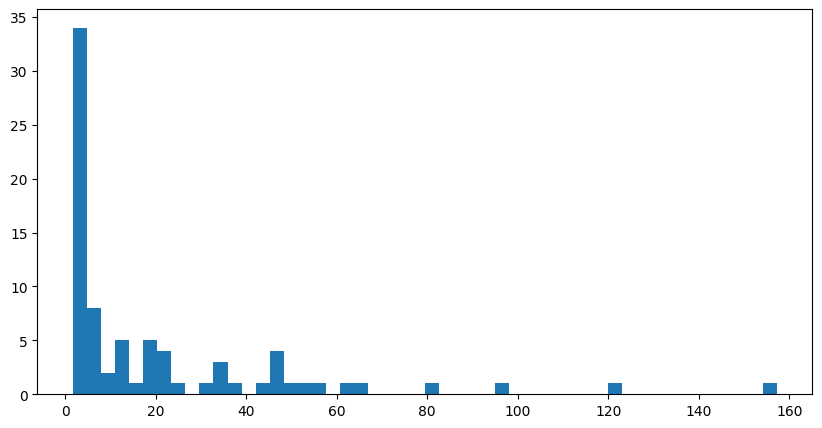

In [50]:
plt.figure(figsize=(10,5))
plt.hist([c.frame_count() / N_FRAMES_IN_SECOND for _, c in chunks], bins=50)
plt.show()

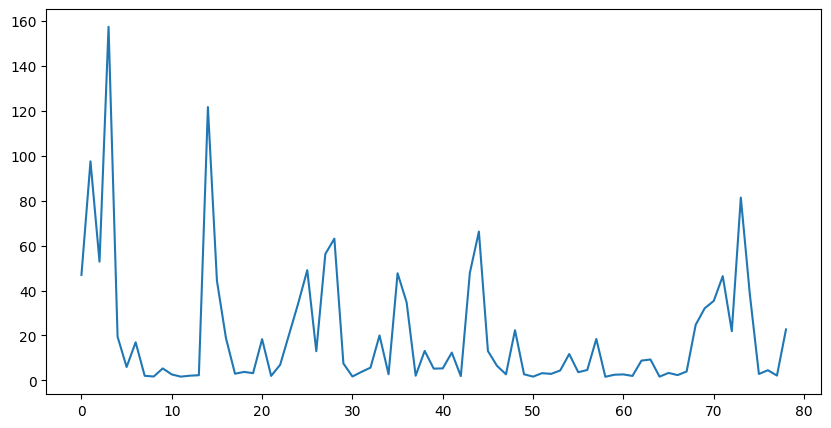

In [62]:
plt.figure(figsize=(10,5))
plt.plot([c.frame_count() / N_FRAMES_IN_SECOND for _, c in chunks])
plt.show()

In [69]:
result = transcribe_large_audio(chunks, language)

0it [00:00, ?it/s]

audio-chunks/chunk1.wav : Получаете супер кэшбэк бесплатная дебетовая альфа карта закажите в апреле и получите 1000руб ребята всем привет это канал импроком это шоу громкий вопрос всем привет друзья сразу перед тем как начнём хочу вам сказать вы иногда забывайте подписаться на наш замечательный канал я скажу это вначале что вы сейчас не забыли подпишитесь на канал чтобы не пропускать видосы на мой я на его тоже. 
audio-chunks/chunk2.wav : Фамилия которого мечтает каждый граф великолепный stand up комик сергей орлов нарядный пришёл на передачу пришёл на передачу с правильно как у тебя дела всё хорошо всё нормально каким хреном вы укладывать волосы я всё нам вообще не пользуюсь у меня руки вот так вот вот так вот потому что он нужен aviasales чтобы отслеживать покупки и поиску дешёвых авиабилетов свяжитесь с нами лучше не будет это даже скорее вот эта песня а какие-то мне уже приносили я уже разгонял с авторской группой зал. 
audio-chunks/chunk3.wav : Ты смотрел хоть один выпуск нашёл я 

audio-chunks/chunk72.wav : Просто среди них есть ещё и согласно можно как-то ебаться я же все написал какой нет давайте какой гласный тут нет а мне нравится тебе написал весь алфавит напишите только гласные буквы напишите я написал да вы сами считаете что ваш ответ да-да но есть проблема только да или нет мой товарищ по команде не может тянуть букву и не могу. 
audio-chunks/chunk73.wav : Она прикурила блядь raquo скинул слушать такие претензии иногда такие подожди ну как так нельзя тоже рассуждать назови хоть одно слово и не вспомнила. 
audio-chunks/chunk74.wav : Ну ты что ты за вопросы не документы надо писать ну как посчитать в одной игре я перепутал перепутал не знал перепутал название площадей в санкт-петербург ну я подумал раз нашей команде не все знают буквы я ю е 456789 10 выигрыш ёбанный лотерею но не написал я подписал добавил одну нельзя у него забрать ту которую он добавил сюда и краткая добавил блин. 
audio-chunks/chunk75.wav : У меня на одну рот количество а нет вопроса пр

# Video Face Recognition

In [75]:
import cv2
import face_recognition
import numpy as np

In [82]:
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 640)

True

In [83]:
mouth_pts = []

In [84]:
while True:
    # Grab a single frame of video
    ret, frame = cap.read()

    face_landmarks = face_recognition.face_landmarks(frame)
    
    try:
        p1=face_landmarks[0]['top_lip']
        p2=face_landmarks[0]['bottom_lip']
        x1,y1=p1[9]
        x3,y3=p1[8]
        x4,y4=p1[10]
        x2,y2=p2[9]
        x5,y5=p2[8]
        x6,y6=p2[10]
        
        mouth_pts += [[p1[8], p1[9], p1[10], 
                       p2[8], p2[9], p2[10]]]
        
        dist = np.sqrt(((x2+x5+x6) - (x1+x3+x4)) ** 2 + ((y2+y5+y6) - (y1+y3+y4)) ** 2)
        image = cv2.circle(frame, p1[8], 1, (255, 255, 255, 0), 2)
        image = cv2.circle(frame, p1[9], 1, (255, 255, 255, 0), 2)
        image = cv2.circle(frame, p1[10], 1, (255, 255, 255, 0), 2)

        image = cv2.circle(frame, p2[8], 1, (255, 255, 255, 0), 2)
        image = cv2.circle(frame, p2[9], 1, (255, 255, 255, 0), 2)
        image = cv2.circle(frame, p2[10], 1, (255, 255, 255, 0), 2)
        # # cv2.clipLine(frame, p1, p2,(255,255,255,0), thickness=2)
        # for p1t in p1:
        #     image = cv2.circle(frame, p1t, 1, (255,255,255,0), 2)
        # for p1b in p2:
        #     image = cv2.circle(frame, p1b, 1, (255, 255, 255, 0), 2)

        cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
        cv2.imshow('Video', frame)
    except Exception as e:
        cap.release()
        cv2.destroyAllWindows()
        raise(e)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break



# video_capture.release()
# cv2.destroyAllWindows()

KeyboardInterrupt: 

In [85]:
import numpy as np

In [86]:
mouth_pts = np.array(mouth_pts)

In [47]:
def sum_tri_volume(pts):
    cent = pts.mean(axis=0)
    
    s = 0
    for i in range(len(pts)):
        a = np.linalg.norm(pts[i] - pts[i - 1])
        b = np.linalg.norm(pts[i] - cent)
        c = np.linalg.norm(pts[i - 1] - cent)
                
        p = (a + b + c) / 2
        s += np.sqrt(p * (p - a) * (p - b) * (p - c))
    
    return s

def volume(pts, method="sum_tri"):
    return eval(method + "_volume")(pts)

In [98]:
volume(mouth_pts)

16748.235199479204

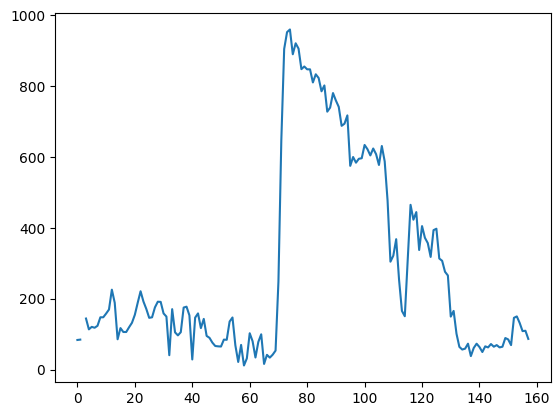

In [92]:
import matplotlib.pyplot as plt


plt.plot([volume(m) for m in mouth_pts])
plt.show()


# Synchronization

# SANDBOX

In [4]:
dir_path = "/Users/andreyignatov/Downloads/Object-Detection-main/"

class_file = "coco.names"
with open(dir_path + class_file, "rt") as f:
    class_names = f.read().rstrip("\n").split("\n")
    
config_file = "ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt"
weights_file = "frozen_inference_graph.pb"

net = cv2.dnn_DetectionModel(dir_path + weights_file, 
                             dir_path + config_file)
net.setInputSize(320, 320)
net.setInputScale(1.0 / 127.5)
net.setInputMean((127.5, 127.5, 127.5))
net.setInputSwapRB(True)

< cv2.dnn.Model 0x11ecc1e70>

In [5]:
while True:
    success, img = cap.read()
    if img is None:
        print("Check video in")
        continue
    else:
        class_ids, confs, bbox = net.detect(img, confThreshold=0.5)
        
    if len(class_ids) > 0:
        for class_id, conf, box in zip(class_ids.flatten(), 
                                       confs.flatten(), 
                                       bbox):
            label = class_names[class_id - 1].upper()
            confidence = round(conf * 100, 2)
            if label == "PERSON" and confidence > 60:
                cv2.rectangle(img, box, color=(0, 255, 0), thickness=2)
                cv2.putText(img, label, 
                            (box[0] + 10, 
                             box[1] + 30), 
                            cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Out", img)
    cv2.waitKey(1)

KeyboardInterrupt: 